# Constants

In [1]:
import os

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'  # this is required
os.environ['CUDA_VISIBLE_DEVICES'] = '2'         # set to '0' for GPU0, '1' for GPU1 or '2' for GPU2. Check "gpustat" in a terminal.

In [2]:
glob_path = '/opt/iui-datarelease3-sose2021/*.csv'

pickle_file = '../data.pickle'

# Config

In [3]:
# Possibilities: 'SYY', 'SYN', 'SNY', 'SNN', 
#                'JYY', 'JYN', 'JNY', 'JNN'
cenario = 'SYN' 

win_sz = 10
stride_sz = 5

# divisor for neuron count step downs (hard to describe), e.g. dense_step = 3: layer1=900, layer2 = 300, layer3 = 100, layer4 = 33...
dense_steps = 3
# amount of dense/dropout layers
layer_count = 3
# how much to drop
drop_count = 0.1

# Helper Functions

In [4]:
from matplotlib import pyplot as plt

def pplot(dd):
    x = dd.shape[0]
    fix = int(x/3)+1
    fiy = 3
    fig, axs = plt.subplots(fix, fiy, figsize=(3*fiy, 9*fix))
    
    for i in range(x):
        axs[int(i/3)][i%3].plot(dd[i])

# Loading Data

In [5]:
from glob import glob
import pandas as pd
from tqdm import tqdm

def dl_from_blob(filename, user_filter=None):
    
    dic_data = []
    
    for p in tqdm(glob(glob_path)):
        path = p
        filename = path.split('/')[-1].split('.')[0]
        splitname = filename.split('_')
        user = int(splitname[0][1:])
        if (user_filter):
            if (user != user_filter):
                continue
        scenario = splitname[1][len('Scenario'):]
        heightnorm = splitname[2][len('HeightNormalization'):] == 'True'
        armnorm = splitname[3][len('ArmNormalization'):] == 'True'
        rep =  int(splitname[4][len('Repetition'):])
        session =  int(splitname[5][len('Session'):])
        data = pd.read_csv(path)
        dic_data.append(
            {
                'filename': path,
                'user': user,
                'scenario': scenario,
                'heightnorm': heightnorm,
                'armnorm': armnorm,
                'rep': rep,
                'session': session,
                'data': data 
            }
        )
    return dic_data

In [6]:
import pickle

def save_pickle(f, structure):
    _p = open(f, 'wb')
    pickle.dump(structure, _p)
    _p.close()

In [7]:
def load_pickles(f) -> list:
    _p = open(pickle_file, 'rb')
    _d = pickle.load(_p)
    _p.close()
    
    return _d

In [8]:
%%time

def load_data() -> list:
    if os.path.isfile(pickle_file):
        print(f'{pickle_file} found...')
        return load_pickles(pickle_file)
    print(f'Didn\'t find {pickle_file}...')
    all_data = dl_from_blob(glob_path)
    print(f'Creating {pickle_file}...')
    save_pickle(pickle_file, all_data)
    return all_data

print("Loading data...")
dic_data = load_data()
print(len(dic_data))

Loading data...
../data.pickle found...
768
CPU times: user 596 ms, sys: 2.15 s, total: 2.75 s
Wall time: 2.75 s


In [9]:
%%time

# Categorized Data
cdata = dict() 
# Sorting, HeightNorm, ArmNorm
cdata['SYY'] = list() 
cdata['SYN'] = list() 
cdata['SNY'] = list() 
cdata['SNN'] = list() 

# Jenga, HeightNorm, ArmNorm
cdata['JYY'] = list() 
cdata['JYN'] = list() 
cdata['JNY'] = list() 
cdata['JNN'] = list() 
for d in dic_data:
    if d['scenario'] == 'Sorting':
        if d['heightnorm']:
            if d['armnorm']:
                cdata['SYY'].append(d)
            else:
                cdata['SYN'].append(d)
        else:
            if d['armnorm']:
                cdata['SNY'].append(d)
            else:
                cdata['SNN'].append(d)
    elif d['scenario'] == 'Jenga':
        if d['heightnorm']:
            if d['armnorm']:
                cdata['JYY'].append(d)
            else:
                cdata['JYN'].append(d)
        else:
            if d['armnorm']:
                cdata['JNY'].append(d)
            else:
                cdata['JNN'].append(d)

CPU times: user 398 µs, sys: 0 ns, total: 398 µs
Wall time: 402 µs


# Preprocessing

In [10]:
def drop(entry) -> pd.DataFrame:
    droptable = ['participantID', 'FrameID', 'Scenario', 'HeightNormalization', 'ArmNormalization', 'Repetition', 'Session', 'Unnamed: 0']
    centry = pickle.loads(pickle.dumps(entry))
    return centry['data'].drop(droptable, axis=1)

In [11]:
def floatize(entry) -> pd.DataFrame:
    centry = pickle.loads(pickle.dumps(entry))
    centry['data']['LeftHandTrackingAccuracy'] = (entry['data']['LeftHandTrackingAccuracy'] == 'High') * 1.0
    centry['data']['RightHandTrackingAccuracy'] = (entry['data']['RightHandTrackingAccuracy'] == 'High') * 1.0
    return centry['data']

In [12]:
import numpy as np
right_Hand_ident='right_Hand'
left_Hand_ident='left_hand'

def rem_low_acc(entry) -> pd.DataFrame:
    centry = pickle.loads(pickle.dumps(entry))
    right_Hand_cols = [c for c in centry['data'] if right_Hand_ident in c]
    left_Hand_cols = [c for c in centry['data'] if left_Hand_ident in c]
    
    centry['data'].loc[centry['data']['RightHandTrackingAccuracy'] == 0.0, right_Hand_cols] = np.nan
    centry['data'].loc[centry['data']['LeftHandTrackingAccuracy'] == 0.0, left_Hand_cols] = np.nan
    return centry['data']

In [13]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

stride = 150
def pad(entry) -> pd.DataFrame:
    centry = pickle.loads(pickle.dumps(entry))
    cols = centry['data'].columns
    pentry = pad_sequences(centry['data'].T.to_numpy(),
                                        maxlen=(int(centry['data'].shape[0]/stride)+1)*stride,
                                        dtype='float64',
                                        padding='pre', 
                                        truncating='post',
                                        value=np.nan
                                       ) 
    pdentry = pd.DataFrame(pentry.T, columns=cols)
    pdentry.loc[0] = [0 for _ in cols]
    return pdentry

In [14]:
def interpol(entry) -> pd.DataFrame:
    centry = pickle.loads(pickle.dumps(entry))
    return centry['data'].interpolate(method='linear', axis=0)

In [15]:
from tensorflow.keras.preprocessing import timeseries_dataset_from_array

def slicing(entry):
    centry = pickle.loads(pickle.dumps(entry))
    return timeseries_dataset_from_array(
        data=centry['data'], 
        targets=[centry['user'] for _ in range(centry['data'].shape[0])], 
        sequence_length=win_sz,
        sequence_stride=stride_sz, 
        batch_size=8, 
        seed=177013
    )

In [16]:
from sklearn.preprocessing import (StandardScaler, 
                                   MinMaxScaler, 
                                   MaxAbsScaler,
                                   PowerTransformer,
                                   Binarizer)
def scaling(entry,scale):
   
    standard  = StandardScaler()
    max_Abs   = MaxAbsScaler()
    binarizer = Binarizer()
    entry     = entry.to_numpy(dtype=np.float64)
    
    if (scale == 0 ):
        entry = min_Max.fit_transform(entry)
    
    if (scale == 1 ):
        for i in entry:
            entry = standard.fit_transform(entry)
    
    if (scale == 2 ):
        for i in entry:
            entry = max_Abs.fit_transform(entry)
    
    if (scale == 3 ):
        for i in entry:
            entry = binarizer.fit_transform(entry)
    return pd.DataFrame(entry)


def minScale(entry):
    entry     = entry.to_numpy(dtype=np.float64)
    min_Max   = MinMaxScaler()
    entry = min_Max.fit_transform(entry)
    return pd.DataFrame(entry)
    

def stanScale(entry):
    entry     = entry.to_numpy(dtype=np.float64)
    standard  = StandardScaler()
    entry = standard.fit_transform(entry)
    return pd.DataFrame(entry)


    
def maxScale(entry):
    entry     = entry.to_numpy(dtype=np.float64)
    binarizer = Binarizer()
    entry = binarizer.fit_transform(entry)
    return pd.DataFrame(entry)
    
    

def binScale(entry):
    entry     = entry.to_numpy(dtype=np.float64)
    min_Max   = MinMaxScaler()
    entry = min_Max.fit_transform(entry)
    return pd.DataFrame(entry)
    

In [17]:
from sklearn.preprocessing import (StandardScaler, 
                                   MinMaxScaler, 
                                   MaxAbsScaler,
                                   PowerTransformer,
                                   Binarizer)

#%%time

classes = 16 # dynamic

def preproc(data):
    res_list = list()
    temp_list= list()
    for e in tqdm(data):
        res_list.append(preproc_entry(e))
#     for a in tqdm(temp_list):
#         res_list.append(preproc_entry(a))
#     
    return res_list
        
def preproc_entry(entry):
    entry2 = pickle.loads(pickle.dumps(entry))
    entry2['data'] = drop(entry2)
    
    entry3 = pickle.loads(pickle.dumps(entry2))
    entry3['data'] = floatize(entry3)
    
    entry4 = pickle.loads(pickle.dumps(entry3))
    entry4['data'] = rem_low_acc(entry4)
    
    
    
    entry5 = pickle.loads(pickle.dumps(entry4))
    entry5['data'] = pad(entry5)
    
    entry6 = pickle.loads(pickle.dumps(entry5))
    entry6['data'] = interpol(entry6)
    
    entry8 = pickle.loads(pickle.dumps(entry6))
    entry8['data'] = minScale(entry8['data']) # 0 = minmax, 1 = standard, 2 = maxabs, 3 = binarizer
    
    entry7 = pickle.loads(pickle.dumps(entry8))
    entry7['data'] = slicing(entry7)
    
   
    
    
    return entry7




pdata = preproc(cdata[cenario])


100%|██████████| 96/96 [00:16<00:00,  5.95it/s]


# Building Model

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout, LSTM
import tensorflow.keras as keras

def build_model(shape, classes):
    
    model = Sequential()
    ncount = shape[0]*shape[1]
    
    model.add(Flatten(input_shape=shape))
    
    model.add(Dropout(drop_count))
    model.add(BatchNormalization())
    
    for i in range(1,layer_count):
        neurons = int(ncount/pow(dense_steps,i))
        if neurons <= classes*dense_steps:
            break
        model.add(Dropout(drop_count*i))
        model.add(Dense(neurons, activation='relu'))
    
    model.add(Dense(classes, activation='softmax'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(0.001),
        loss="categorical_crossentropy", 
        metrics=["acc"],
    )

    return model



In [19]:
checkpoint_file = './goat.weights'

def train_model(X_train, y_train, X_test, y_test):
    model = build_model(X_train[0].shape, 16)
    
    model.summary()

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath = checkpoint_file,
        save_weights_only=True,
        monitor='val_acc',
        mode='max',
        save_best_only=True
    )
        
    history = model.fit(X_train, 
                        y_train,
                        epochs=30,
                        batch_size=128,
                        shuffle=True,
                        verbose=2,
                        validation_data=(X_test, y_test),
                        callbacks=[model_checkpoint_callback]
                        
             )
    return model, history


    

In [20]:
%%time
train = np.array([x['data'] for x in pdata if x['session'] == 1])
test = np.array([x['data'] for x in pdata if x['session'] == 2])

len(train), len(test)

CPU times: user 375 µs, sys: 0 ns, total: 375 µs
Wall time: 396 µs


(48, 48)

In [21]:
%%time

X_train = list()
y_train = list()

X_test = list()
y_test = list()

train = list()
test = list()

for x in pdata:
    if x['session'] == 1:
        train.append(
            {
                'label': x['user'],
                'data': list()
            })
        for y in x['data'].unbatch().as_numpy_iterator():
            X_train.append(y[0])
            y_train.append(y[1])
            
            train[-1]['data'].append(y[0])
    if x['session'] == 2:
        test.append(
            {
                'label': x['user'],
                'data': list()
            })
        for y in x['data'].unbatch().as_numpy_iterator():
            X_test.append(y[0])
            y_test.append(y[1])
            
            test[-1]['data'].append(y[0])

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

CPU times: user 25.7 s, sys: 6.87 s, total: 32.6 s
Wall time: 9.2 s


In [22]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((30432, 10, 338), (30432,), (20502, 10, 338), (20502,))

In [23]:
%%time

from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
yy_train = lb.fit_transform(y_train)
yy_test = lb.fit_transform(y_test)

for e in test:
    e['label'] = lb.transform([e['label']])
    e['data'] = np.array(e['data'])
    
for e in train:
    e['label'] = lb.transform([e['label']])
    e['data'] = np.array(e['data'])


CPU times: user 241 ms, sys: 116 ms, total: 358 ms
Wall time: 357 ms


In [24]:
print(X_train.shape)
print(yy_train.shape)
print(X_test.shape)
print(yy_test.shape)

(30432, 10, 338)
(30432, 16)
(20502, 10, 338)
(20502, 16)


In [25]:
%%time

model, history = train_model(np.array(X_train), np.array(yy_train), np.array(X_test), np.array(yy_test))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3380)              0         
_________________________________________________________________
dropout (Dropout)            (None, 3380)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 3380)              13520     
_________________________________________________________________
dropout_1 (Dropout)          (None, 3380)              0         
_________________________________________________________________
dense (Dense)                (None, 1126)              3807006   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1126)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 375)               4

# Eval

In [26]:
def predict(model, entry):
    p_dict = dict()
    predictions = np.argmax(model.predict(entry['data']), axis=-1)
    for p in predictions:
        if p in p_dict:
            p_dict[p] += 1
        else:
            p_dict[p] = 1
    prediction = max(p_dict, key=p_dict.get)
    return prediction+1

In [27]:
%%time

ltest = [lb.inverse_transform(e['label'])[0] for e in test]
ptest = [predict(model, e) for e in test]

# for e in test:
#     print(f"Label:      {lb.inverse_transform(e['label'])[0]:2d}")
#     print(f"Prediction: {predict(model, e):2d}\n_______________")

CPU times: user 2.59 s, sys: 335 ms, total: 2.92 s
Wall time: 2.17 s


In [28]:
%%time

ltrain = [lb.inverse_transform(e['label'])[0] for e in train]
ptrain = [predict(model, e) for e in train]

# for e in train:
#     print(f"Label:      {lb.inverse_transform(e['label'])[0]:2d}")
#     print(f"Prediction: {predict(model, e):2d}\n_______________")

CPU times: user 3.2 s, sys: 264 ms, total: 3.47 s
Wall time: 2.44 s


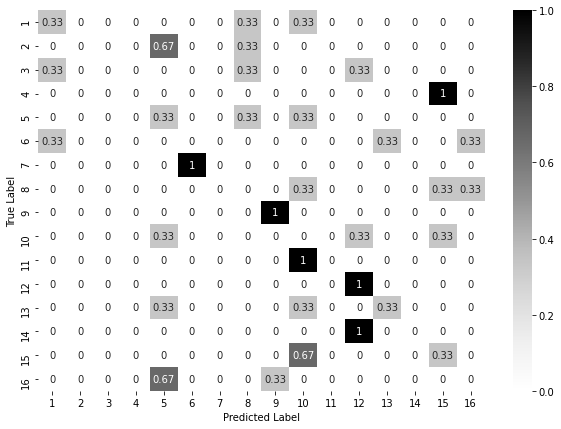

              precision    recall  f1-score   support

           1       0.33      0.33      0.33         3
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         3
           5       0.14      0.33      0.20         3
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00         3
           9       0.75      1.00      0.86         3
          10       0.00      0.00      0.00         3
          11       0.00      0.00      0.00         3
          12       0.38      1.00      0.55         3
          13       0.50      0.33      0.40         3
          14       0.00      0.00      0.00         3
          15       0.17      0.33      0.22         3
          16       0.00      0.00      0.00         3

    accuracy                           0.21        48
   macro avg       0.14   

In [29]:
%%time

from sklearn.metrics import confusion_matrix
import seaborn as sn

from sklearn.metrics import classification_report

set_digits = { 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16 }

train_cm = confusion_matrix(ltrain, ptrain, normalize='true')
test_cm = confusion_matrix(ltest, ptest, normalize='true')

df_cm = pd.DataFrame(test_cm, index=set_digits, columns=set_digits)
plt.figure(figsize = (10,7))
sn_plot = sn.heatmap(df_cm, annot=True, cmap="Greys")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

print(classification_report(ltest, ptest, zero_division=0))

In [30]:
print(f'cenario: {cenario}')
print(f'win_sz: {win_sz}')
print(f'stride_sz: {stride_sz}')
print(f'dense_steps: {dense_steps}')
print(f'layer_count: {layer_count}')
print(f'drop_count: {drop_count}')



cenario: SYN
win_sz: 10
stride_sz: 5
dense_steps: 3
layer_count: 3
drop_count: 0.1


In [31]:
exit()